Importing the necessary modules

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy import stats
import seaborn as sns
from functools import partial
import multiprocessing
from time import sleep

Opening the extracted file

In [5]:
f = open("lichess_db_standard_rated_2013-01.pgn")
data = f.read()
data = str(data)

Extracting the various data fields and elementary data analysis

Number of total games: 121332
Number of normal games: 120691
Number of games with eval attached: 641
Number of empty games: 0


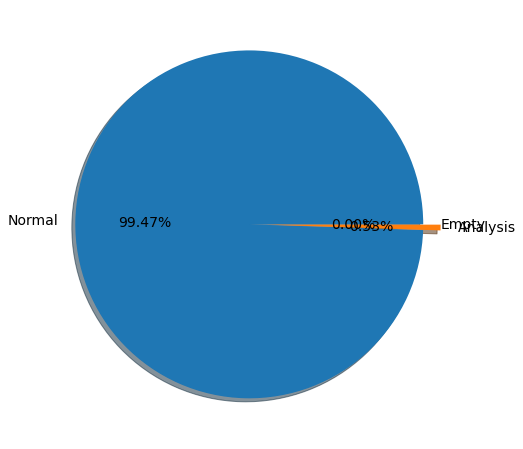

In [6]:
raw_games = data.split('[Event')
del raw_games[0]
analysis_games = 0
empty_games = 0
for game in raw_games:
    if game.find('eval') != -1:
        analysis_games += 1

for game in raw_games:
    if game.find('1.') == -1:
        empty_games += 1
normal_games = len(raw_games) - analysis_games - empty_games

print("Number of total games: %d" % len(raw_games))
print("Number of normal games: %d" % normal_games)
print("Number of games with eval attached: %d" % analysis_games)
print("Number of empty games: %d" % empty_games)





explode = [0, 0.1, 0]
plt.figure(figsize=(12, 8))
labels = ['Normal', 'Analysis', 'Empty']
pie_data = [normal_games / len(raw_games), analysis_games / len(raw_games), empty_games / len(raw_games)]
plt.pie(pie_data, labels=labels, autopct='%1.2f%%', shadow=True, explode=explode, textprops={'fontsize': 14})
plt.show()

Adding the obtained data to lists

In [7]:
all_games = []
for i in range(len(raw_games)):
    if raw_games[i].find('eval') != -1 or raw_games[i].find('1.') == -1:
        continue
    else:
        all_games.append(raw_games[i])

del raw_games

PGN_list = []
mode_list = []
result_list = []
avg_rating_list = []
rating_diff_list = []
termination_list = []



for game in all_games:
    start_index = game.find("1. ")
    end_index = start_index
    while True:
        if game[end_index:end_index + 2] == '0-' or game[end_index:end_index + 2] == '1-' or game[end_index:end_index + 2] == '1/':
            # Game termination
            break
        end_index += 1
    PGN_list.append(game[start_index:end_index])

    # Mode
    index = game.find("d") + 2
    s = ""
    while True:
        if game[index] == " ":
            break
        s += game[index]
        index += 1
    mode_list.append(s)



    # Result
    index = game.find('Result') + 8
    result = game[index:index + 2]
    if result == "1-":
        result_list.append("White Wins")
    elif result == "0-":
        result_list.append("Black Wins")
    elif result == "1/":
        result_list.append("Draw")

    # Rating
    wIndex = game.find('WhiteElo') + 10
    bIndex = game.find('BlackElo') + 10
    wString = ""
    if game[wIndex] != "?" and game[bIndex] != "?":
        while True:
            # Use a loop in case there's a rating <1000
            if game[wIndex] == '"':
                break
            wString += game[wIndex]
            wIndex += 1

        bString = ""
        while True:
            if game[bIndex] == '"':
                break
            bString += game[bIndex]
            bIndex += 1

        wRating = int(wString)
        bRating = int(bString)
        avg_rating_list.append(math.ceil((wRating+bRating)/2))
        rating_diff_list.append(wRating-bRating)
    else:
        if game[wIndex] == "?" and game[bIndex] != "?":
            bString = ""
            while True:
                if game[bIndex] == '"':
                    break
                bString += game[bIndex]
                bIndex += 1

            wRating = 1500
            bRating = int(bString)
            avg_rating_list.append(math.ceil((wRating + bRating) / 2))
            rating_diff_list.append(wRating - bRating)
        if game[wIndex] != "?" and game[bIndex] == "?":
            while True:
                # Use a loop in case there's a rating <1000
                if game[wIndex] == '"':
                    break
                wString += game[wIndex]
                wIndex += 1
            wRating = int(wString)
            bRating = 1500
            avg_rating_list.append(math.ceil((wRating + bRating) / 2))
            rating_diff_list.append(wRating - bRating)
        if game[wIndex] == "?" and game[bIndex] == "?":
            wRating = 1500
            bRating = 1500
            avg_rating_list.append(math.ceil((wRating + bRating) / 2))
            rating_diff_list.append(wRating - bRating)


    # Termination
    index = game.find("[Termination")
    quotes = 0
    s = ""
    while quotes < 2:
        if game[index] == '"':
            quotes += 1
        elif quotes == 1:
            s += game[index]
        index += 1

    termination_list.append(s)

Saving the data in a pandas dataframe and converting to csv format

In [8]:
chess_df = pd.DataFrame({})
chess_df['PGN'] = PGN_list
chess_df['Mode'] = mode_list
chess_df['Result'] = result_list
chess_df['Average Rating'] = avg_rating_list
chess_df['Rating Difference'] = rating_diff_list
chess_df['Termination Type'] = termination_list
chess_df.to_csv("lichess-08-2014.csv", index=True, header=True)

More preliminary analysis

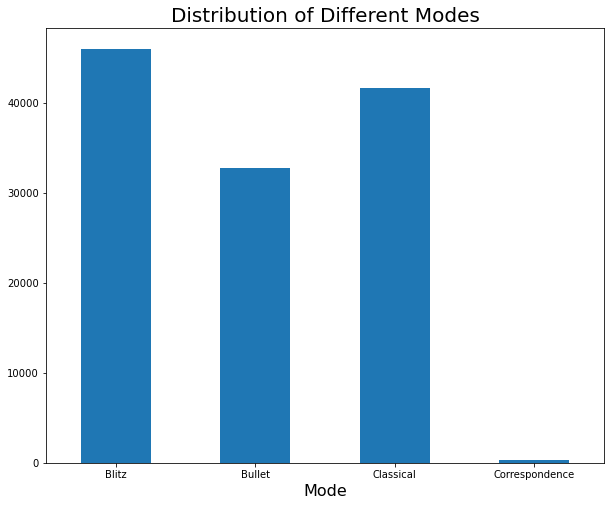

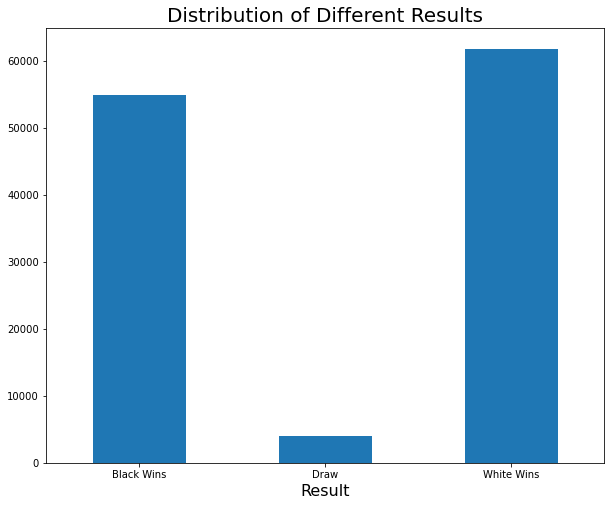

Termination Type
Normal          82987
Time forfeit    37704
Name: Mode, dtype: int64


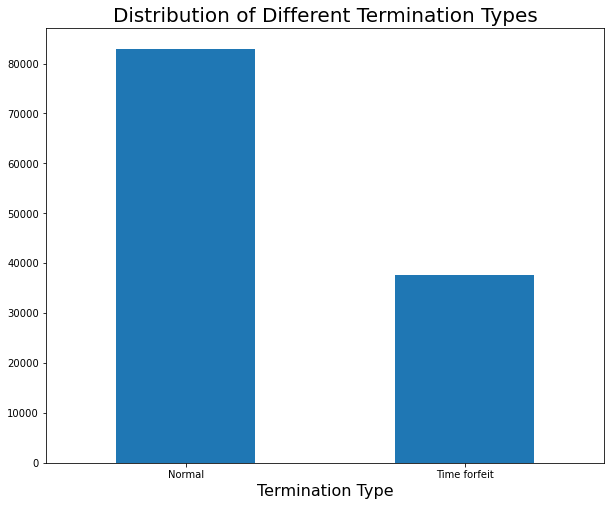

In [10]:
def general_eda(label, print_now=False):
    dist_list = chess_df.groupby(label).count().iloc[:, 1]
    if print_now:
        print(dist_list)

    plt.figure(figsize=(10, 8))
    dist_list.plot.bar(rot=0)
    plt.xlabel(label, fontsize=16)
    plt.title("Distribution of Different %ss" % label, fontsize=20)
    plt.show()

general_eda('Mode')
general_eda('Result')
general_eda('Termination Type', print_now=True)

Mean of Average Ratings: 1600.348
Median of Average Ratings: 1593.000
Standard Deviation of Average Ratings: 179.181
95% confidence interval: 1241.986 to 1958.710
95% of data is between 1265.000 and 1968.000
Skew of the distribution is 0.147


C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


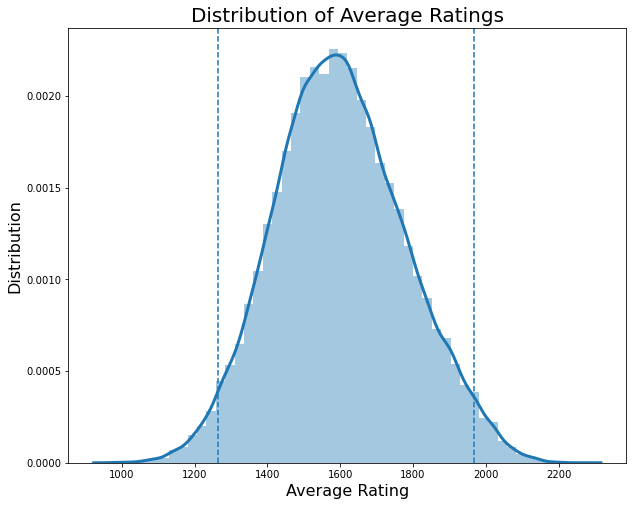

In [15]:
avg_rat = chess_df['Average Rating']
print("Mean of Average Ratings: %.3f" % np.mean(avg_rat))
print("Median of Average Ratings: %.3f" % np.median(avg_rat))
print("Standard Deviation of Average Ratings: %.3f" % np.std(avg_rat))
intv1 = np.mean(avg_rat)-2*np.std(avg_rat)
intv2 = np.mean(avg_rat)+2*np.std(avg_rat)
print("95%c confidence interval: %.3f to %.3f" % ('%', intv1, intv2))
quant1 = np.quantile(avg_rat, 0.025)
quant2 = np.quantile(avg_rat, 0.975)
print("95%c of data is between %.3f and %.3f" % ('%', quant1, quant2))
print("Skew of the distribution is %.3f" % (stats.skew(avg_rat)))

plt.figure(figsize=(10, 8))
sns.distplot(avg_rat, kde_kws={'linewidth': 3})
plt.axvline(x=quant1, linestyle='--', markersize=12)
plt.axvline(x=quant2, linestyle='--', markersize=12)
plt.xlabel("Average Rating", fontsize=16)
plt.ylabel("Distribution", fontsize=16)
plt.title("Distribution of Average Ratings", fontsize=20)
plt.show()

In [16]:
print("Rating below 1250 (Beginner): %d" % (np.count_nonzero(avg_rat < 1250)))
print("Rating 1250 - 1750 (Intermediate): %d" % (np.count_nonzero(avg_rat < 1750) - np.count_nonzero(avg_rat < 1250)))
print("Rating 1750 - 2250 (Advanced): %d" % (np.count_nonzero(avg_rat < 2250) - np.count_nonzero(avg_rat < 1750)))
print("Rating above 2250 (Master): %d" % (np.count_nonzero(avg_rat >= 2250)))

Rating below 1250 (Beginner): 2351
Rating 1250 - 1750 (Intermediate): 93636
Rating 1750 - 2250 (Advanced): 24703
Rating above 2250 (Master): 1


Mean of Average Ratings: 9.976
Median of Average Ratings: 8.000
Standard Deviation of Average Ratings: 202.611
95% confidence interval: -395.246 to 415.198
95% of data is between -399.000 and 427.000
Skew of the distribution is 0.049
Kurtosis of the distribution is 1.080
Exccess kurtosis of the distribution is -1.920


C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


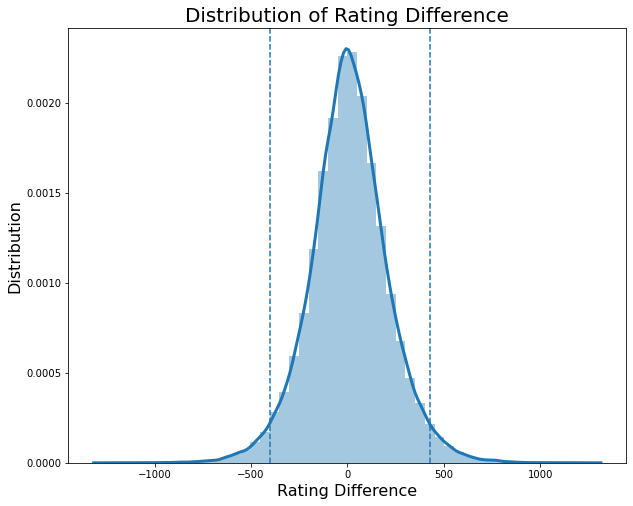

In [17]:
rating_diff = chess_df['Rating Difference']
print("Mean of Average Ratings: %.3f" % np.mean(rating_diff))
print("Median of Average Ratings: %.3f" % np.median(rating_diff))
print("Standard Deviation of Average Ratings: %.3f" % np.std(rating_diff))
intv1 = np.mean(rating_diff)-2*np.std(rating_diff)
intv2 = np.mean(rating_diff)+2*np.std(rating_diff)
print("95%c confidence interval: %.3f to %.3f" % ('%', intv1, intv2))
quant1 = np.quantile(rating_diff, 0.025)
quant2 = np.quantile(rating_diff, 0.975)
print("95%c of data is between %.3f and %.3f" % ('%', quant1, quant2))
print("Skew of the distribution is %.3f" % (stats.skew(rating_diff)))
print("Kurtosis of the distribution is %.3f" % (stats.kurtosis(rating_diff)))
print("Exccess kurtosis of the distribution is %.3f" % (stats.kurtosis(rating_diff)-3))

plt.figure(figsize=(10, 8))
sns.distplot(rating_diff, kde_kws={'linewidth': 3})
plt.axvline(x=quant1, linestyle='--', markersize=12)
plt.axvline(x=quant2, linestyle='--', markersize=12)
plt.xlabel("Rating Difference", fontsize=16)
plt.ylabel("Distribution", fontsize=16)
plt.title("Distribution of Rating Difference", fontsize=20)
plt.show()

In [20]:
splits = multiprocessing.cpu_count()

def multi_split(chess_df, splits):
    if __name__ == "__main__":
        length = len(chess_df)
        steps = math.ceil(length/splits)
        input_games = []
        for x in range(splits):
            input_games.append(chess_df[steps*x:steps*(x+1)].reset_index())
    
    return input_games

input_games = multi_split(chess_df, splits)

In [21]:
length_arr = []

for game in chess_df['PGN']:
    curr_length = 1
    spaces = 0
    for index in range(len(game)):
        if game[index] == " ":
            spaces += 1
            if spaces == 3:
                curr_length += 1
                spaces = 0
        index += 1
    length_arr.append(curr_length)
    
chess_df['Moves'] = length_arr

In [22]:
length_arr = []

for game in chess_df['PGN']:
    curr_length = 1
    spaces = 0
    for index in range(len(game)):
        if game[index] == " ":
            spaces += 1
            if spaces == 3:
                curr_length += 1
                spaces = 0
        index += 1
    length_arr.append(curr_length)
    
chess_df['Moves'] = length_arr

In [23]:
del input_games
input_games = multi_split(chess_df, splits)

In [24]:
def visualize_length(all_lengths, max_length):
    print("Mean Length: %.3f" % np.mean(all_lengths))
    print("Median Length: %.3f" % np.median(all_lengths))
    print("Standard Deviation: %.3f" % np.std(all_lengths))
    print("Longest Game in Dataset: %d moves" % max(all_lengths))
    plt.figure(figsize=(12, 8))
    bins = np.arange(0, max_length, 1)
    plt.title("Distribution of Chess Game Length", fontsize=20)
    plt.xlabel("Number of Moves", fontsize=16)
    plt.ylabel("Percent Distribution", fontsize=16)
    sns.distplot(all_lengths, bins, kde_kws = {'linewidth': 3})
    plt.xlim(0, max_length)
    print("Number of Games that are 1 moves long: %.d\nNumber of Games that are 2 moves long: %.d" % (all_lengths.count(1), all_lengths.count(2)))
    
    return np.mean(all_lengths)

Mean Length: 34.347
Median Length: 32.000
Standard Deviation: 16.353
Longest Game in Dataset: 154 moves


C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Number of Games that are 1 moves long: 0
Number of Games that are 2 moves long: 912


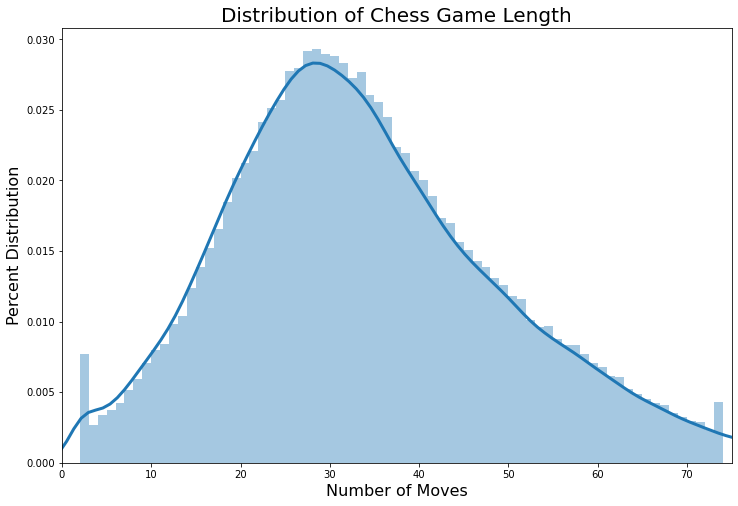

In [25]:
max_moves = 75
mean_length = visualize_length(chess_df['Moves'].tolist(), max_moves)

In [26]:
def termination_game_length(games):
    length_tf = []
    length_normal = []
    for i in range(len(games['PGN'])):
        curr_length = games['Moves'][i]
        if games['Termination Type'][i] == 'Time forfeit':
            length_tf.append(curr_length)
        else:
            length_normal.append(curr_length)
    
    return length_tf, length_normal

%time termination_length_list = termination_game_length(chess_df)

Wall time: 2.75 s


Mean Length Time Forfeit: 33.830
Mean Length Normal: 34.582
Median Length Time Forfeit: 33.000
Median Length Normal: 32.000


C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-l

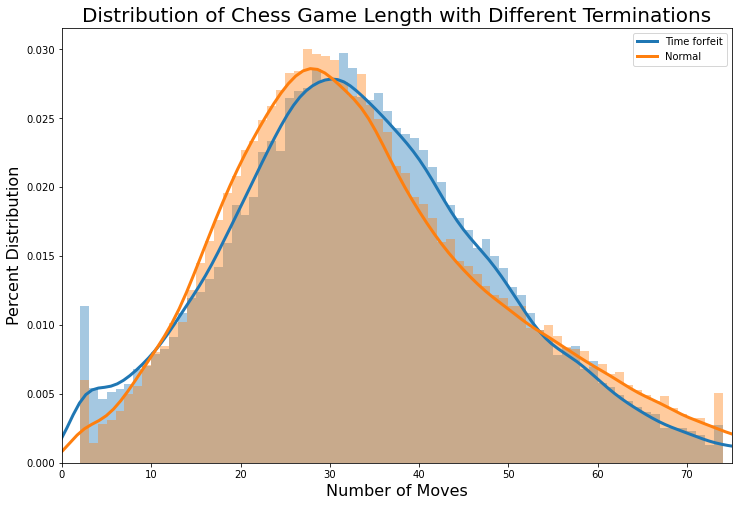

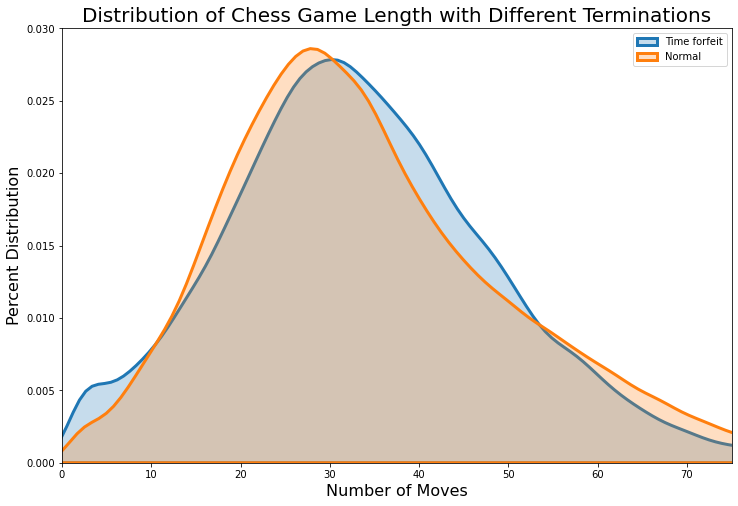

In [27]:
def termination_visualize_length(termination_length_list, max_length, shade=False):
    all_lengths = []
    termination_list = []
    for length in termination_length_list[0]:
        termination_list.append(length)
         
    normal_list = []
    for length in termination_length_list[1]:
        normal_list.append(length)
            
    plt.figure(figsize=(12, 8))
    bins = np.arange(0, max_length, 1)
    plt.title("Distribution of Chess Game Length with Different Terminations", fontsize=20)
    plt.xlabel("Number of Moves", fontsize=16)
    plt.ylabel("Percent Distribution", fontsize=16)
    if shade:
        sns.distplot(termination_list, bins, hist=False, kde_kws = {'linewidth': 3, 'shade': True})
        sns.distplot(normal_list, bins, hist=False, kde_kws = {'linewidth': 3, 'shade': True})
    else:
        print("Mean Length Time Forfeit: %.3f" % np.mean(termination_list))
        print("Mean Length Normal: %.3f" % np.mean(normal_list))
        print("Median Length Time Forfeit: %.3f" % np.median(termination_list))
        print("Median Length Normal: %.3f" % np.median(normal_list))
        sns.distplot(termination_list, bins, kde_kws = {'linewidth': 3})
        sns.distplot(normal_list, bins, kde_kws = {'linewidth': 3})
    plt.xlim(0, max_length)
    plt.legend(["Time forfeit", "Normal"])
termination_visualize_length(termination_length_list, max_moves)
termination_visualize_length(termination_length_list, max_moves, shade=True)

C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

Bullet Mean: 33.776
Blitz Mean: 34.978
Classical Mean: 34.124
Correspondence Mean: 30.457


C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `k

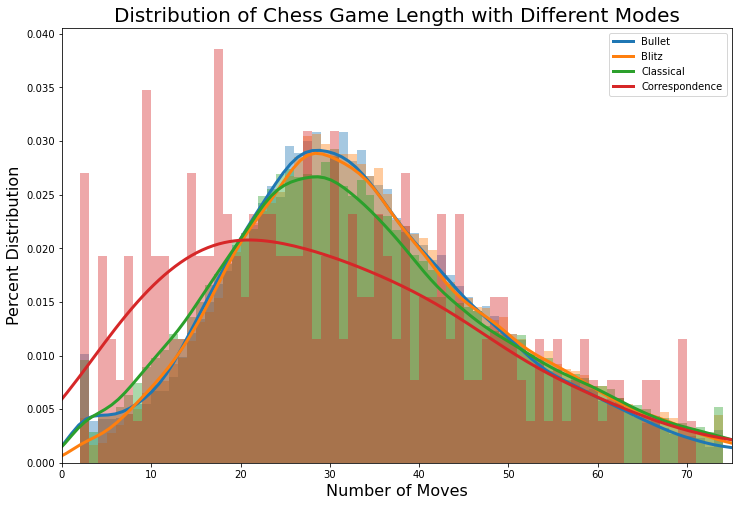

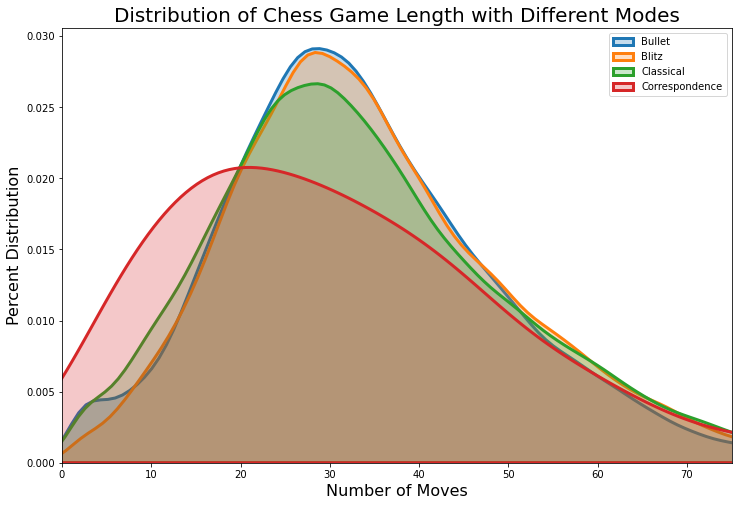

In [28]:
def mode_game_length(games, labels_list):
    mode_dict = {}
    for label in labels_list:
        mode_dict[label] = []
        
    for i in range(len(games['PGN'])):
        curr_length = games['Moves'][i]
        mode_dict[games['Mode'][i]].append(curr_length)
    
    return mode_dict

labels_list = ['Bullet', 'Blitz', 'Classical', 'Correspondence']
mode_length_list = mode_game_length(chess_df, labels_list)
def mode_visualize_length(mode_length_list, max_length, labels_list, shade=False):
    mode_dict = [[] for i in range(len(labels_list))]
    r = 0
    for mode in mode_length_list:
        for length in mode_length_list[mode]:
            mode_dict[r].append(length)
        r += 1
            
    plt.figure(figsize=(12, 8))
    bins = np.arange(0, max_length, 1)
    plt.title("Distribution of Chess Game Length with Different Modes", fontsize=20)
    plt.xlabel("Number of Moves", fontsize=16)
    plt.ylabel("Percent Distribution", fontsize=16)
    if shade:
        for mode in mode_dict:
            sns.distplot(mode, bins, hist=False, kde_kws = {'linewidth': 3, 'shade': True})
    else:
        for mode in mode_dict:
            sns.distplot(mode, bins, kde_kws = {'linewidth': 3})
        r = 0
        for label in labels_list:
            print("%s Mean: %.3f" % (label, np.mean(mode_dict[r])))
            r += 1
    plt.legend(labels_list)
    plt.xlim(0, max_length)
mode_visualize_length(mode_length_list, max_moves, labels_list)
mode_visualize_length(mode_length_list, max_moves, labels_list, shade=True)

C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

750+ Mean: 33.839
1200+ Mean: 37.641
1800+ Mean: 39.112
2000+ Mean: 28.614


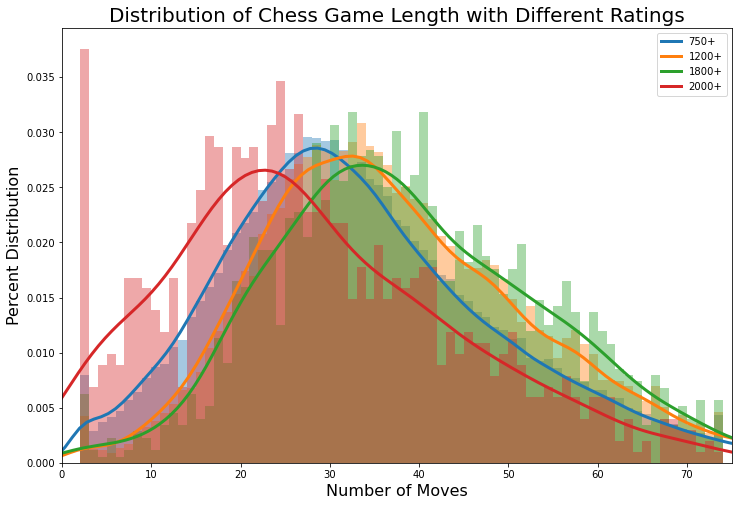

In [33]:
def rating_game_length(games, rating_range=[750, 1200, 1800, 2000]):
    rating_dict = {}
    for rating in rating_range:
        rating_dict[rating] = []
        
    for i in range(len(games['PGN'])):
        rating_type = -1
        for j in range(len(rating_range)):
            if j == 0:
                continue
            if games['Average Rating'][i] > rating_range[j]:
                rating_type = rating_range[j-1]
                
        if rating_type == -1:
            rating_type = 2000
        
        curr_length = games['Moves'][i]
        rating_dict[rating_type].append(curr_length)
    
    return rating_dict

labels_list = ['Bullet', 'Blitz', 'Classical', 'Correspondence']
rating_length_list = rating_game_length(chess_df)
def rating_visualize_length(rating_length_list, max_length, rating_range=[750, 1200, 1800, 2000], shade=False):
    rating_dict = [[] for i in range(len(rating_range))]
    r = 0
    for rating in rating_length_list:
        for length in rating_length_list[rating]:
            rating_dict[r].append(length)
        r += 1
            
    plt.figure(figsize=(12, 8))
    bins = np.arange(0, max_length, 1)
    plt.title("Distribution of Chess Game Length with Different Ratings", fontsize=20)
    plt.xlabel("Number of Moves", fontsize=16)
    plt.ylabel("Percent Distribution", fontsize=16)
    if shade:
        for rating in rating_dict:
            sns.distplot(rating, bins, hist=False, kde_kws = {'linewidth': 3, 'shade': True})
    else:
        for rating in rating_dict:
            sns.distplot(rating, bins, kde_kws = {'linewidth': 3})
        r = 0
        for rating in rating_range:
            print("%s+ Mean: %.3f" % (rating, np.mean(rating_dict[r])))
            r += 1
    
    label_range = []
    for rating in rating_range:
        label_range.append(str(rating) + '+')
    plt.legend(label_range)
    plt.xlim(0, max_length)
rating_visualize_length(rating_length_list, max_moves)

C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Shivam\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `k

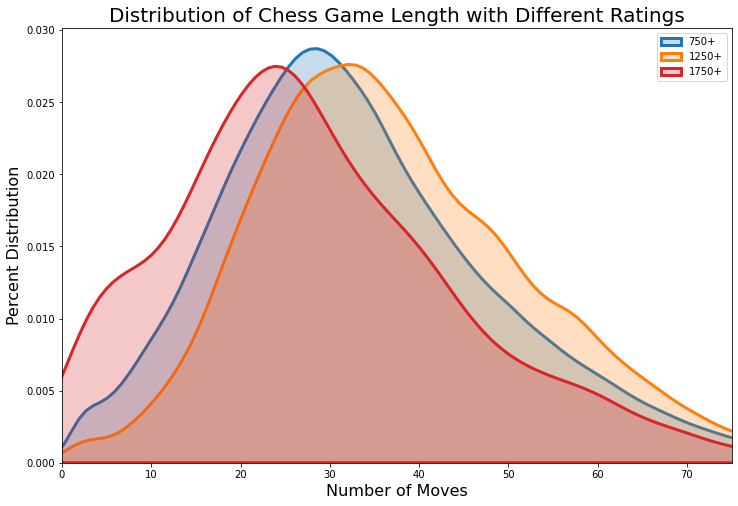

In [30]:
rating_visualize_length(rating_length_list, max_moves, shade=True)

In [ ]:
def total_moves(games):
    moves_dict = {'P': 0, 'B': 0, 'N': 0, 'R': 0, 'Q': 0, 'K': 0, 'O': 0}
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    pieces = ['B', 'N', 'R', 'Q', 'K', 'O']
    for game in games['PGN']:
        curr_move = False
        for index in range(len(game)):
            if game[index] == " ":
                curr_move = False
            elif curr_move:
                continue
            elif game[index] in pawn:
                moves_dict['P'] += 1
                curr_move = True
            elif game[index] in pieces:
                moves_dict[game[index]] += 1
                curr_move = True
    
    return moves_dict

with multiprocessing.Pool(processes=splits) as pool:
    %time moves_list = pool.map(total_moves, input_games)

In [ ]:
def visualize_moves(moves_list, vis_percentage=True, average=False):
    # Preprocessing
    labels = ['Pawn', 'Bishop', 'Knight', 'Rook', 'Queen', 'King', 'Castling']
    M_dict = {}
    for label in moves_list[0]:
        M_dict[label] = 0

    for moves_dict in moves_list:
        for piece in moves_dict:
            M_dict[piece] += moves_dict[piece]

    summ = 0
    for piece in M_dict:
        summ += M_dict[piece]

    M_list = []
    for piece in M_dict:            
        if vis_percentage:
            M_list.append(M_dict[piece]/summ*100)
        else:
            avg = 1
            if average:
                avg = len(chess_df)
            M_list.append(M_dict[piece]/avg)

    # Plotting
    label_pos = np.arange(len(labels))
    plt.figure(figsize=(10, 8))
    plt.title("How many times does each chess piece move?", fontsize=20)
    bar_width = 0.35
    plt.bar(label_pos, M_list, bar_width)
    plt.xticks(label_pos, labels, fontsize=16)
    if vis_percentage:
        plt.ylabel('Percentage', fontsize=16)
    elif average:
        plt.ylabel("Average Number of Moves Per Chess Game", fontsize=16)
        plt.yticks(np.arange(0, 21, 1))
    else:
        plt.ylabel('Total Number of Moves', fontsize=16)
    plt.show()
visualize_moves(moves_list)
visualize_moves(moves_list, vis_percentage=False, average=True)
visualize_moves(moves_list, vis_percentage=False, average=False)

In [ ]:
def prob_over_time(games, max_moves):
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    pieces = ['B', 'N', 'R', 'Q', 'K', 'O']    
    time_dict = {}
    for i in range(1, max_moves+1):
        time_dict[i] = {'P': 0, 'B': 0, 'N': 0, 'R': 0, 'Q': 0, 'K': 0, 'O': 0}
    
    for game in games['PGN']:
        curr_move = False
        curr_length = 1
        spaces = 0
        for index in range(len(game)):
            if game[index] == " ":
                spaces += 1
                if spaces == 3:
                    if curr_length < max_moves:
                        curr_length += 1
                    spaces = 0
                curr_move = False
            elif curr_move:
                continue
            elif game[index] in pawn:
                time_dict[curr_length]['P'] += 1
                curr_move = True
            elif game[index] in pieces:
                time_dict[curr_length][game[index]] += 1
                curr_move = True

    return time_dict

with multiprocessing.Pool(processes=splits) as pool:
    %time time_list = pool.map(partial(prob_over_time, max_moves=max_moves), input_games)

In [ ]:
def visualize_prob_over_time(time_list, max_moves):
    # Preprocessing
    labels = ['Pawn', 'Bishop', 'Knight', 'Rook', 'Queen', 'King', 'Castling']
    T_dict = [[0 for j in range(max_moves)] for i in range(len(labels))]
    
    for time_dict in time_list:
        for time in time_dict:
            r = 0
            for piece in time_dict[time]:
                T_dict[r][time-1] += time_dict[time][piece]
                r += 1
                
    for i in range(max_moves):
        summ = 0
        for t in range(len(labels)):
            summ += T_dict[t][i]
        
        for t in range(len(labels)):
            T_dict[t][i] /= summ/100
    
    plt.figure(figsize=(12, 8))
    
    for i in range(len(labels)):
        plt.plot(np.arange(1, max_moves+1, 1), T_dict[i], linewidth=2)
    
    plt.legend(labels)
    plt.xlim(0, max_moves+1)
    plt.ylim(0, 100)
    plt.title("Probability a Chess Piece Moves on a Given Move", fontsize=20)
    plt.xlabel("Number of Moves", fontsize=16)
    plt.ylabel("Percentage", fontsize=16)
    
visualize_prob_over_time(time_list, max_moves)

In [ ]:
def rating_prob_over_time(games, max_moves, rating_range):
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    pieces = ['B', 'N', 'R', 'Q', 'K', 'O']    
    
    rating_dict = {}
    for rat in range(len(rating_range)+1):
        time_dict = {}
        for i in range(1, max_moves+1):
            time_dict[i] = {'P': 0, 'B': 0, 'N': 0, 'R': 0, 'Q': 0, 'K': 0, 'O': 0}
        rating_dict[rat] = time_dict
    
    r = 0
    for game in games['PGN']:
        curr_move = False
        curr_length = 1
        spaces = 0
        
        curr_avg_rating = games['Average Rating'][r]
        rating_index = 0
        for rat in rating_range:
            if curr_avg_rating < rat:
                break
            else:
                rating_index += 1
                
        for index in range(len(game)):
            if game[index] == " ":
                spaces += 1
                if spaces == 3:
                    if curr_length < max_moves:
                        curr_length += 1
                    spaces = 0
                curr_move = False
            elif curr_move:
                continue
            elif game[index] in pawn:
                rating_dict[rating_index][curr_length]['P'] += 1
                curr_move = True
            elif game[index] in pieces:
                rating_dict[rating_index][curr_length][game[index]] += 1
                curr_move = True
        r += 1

    return rating_dict

with multiprocessing.Pool(processes=splits) as pool:
    rating_range = [1250, 1750, 2250]
    %time rating_time_list = pool.map(partial(rating_prob_over_time, max_moves=max_moves, rating_range=rating_range), input_games)

In [ ]:
def visualize_rating_prob_over_time(rating_time_list, max_moves, rating_range, players=False):
    plt.rcParams.update({'figure.max_open_warning': 0})
    # Preprocessing
    labels = ['Pawn', 'Bishop', 'Knight', 'Rook', 'Queen', 'King', 'Castling']
    R_dict = [[[0 for j in range(max_moves)] for i in range(len(labels))] for k in range(len(rating_range)+1)]
    
    for rating_dict in rating_time_list:
        for rat in rating_dict:
            for time in rating_dict[rat]:
                r = 0
                for piece in rating_dict[rat][time]:
                    R_dict[rat][r][time-1] += rating_dict[rat][time][piece]
                    r += 1
    
    for rat in range(len(R_dict)):            
        for i in range(max_moves):
            summ = 0
            for t in range(len(labels)):
                summ += R_dict[rat][t][i]

            for t in range(len(labels)):
                if summ == 0:
                    summ = 1
                R_dict[rat][t][i] /= summ/100
    
    rating_labels = ['Beginner', 'Intermediate', 'Advanced', 'Master']
    
    if not players:
        fig, ax = plt.subplots(int((len(rating_range)+1)/2), 2, figsize=(20, 15))
        for j in range(len(rating_range)+1):
            ind1 = int(j/2)
            ind2 = j%2
            for i in range(len(labels)):
                ax[ind1][ind2].plot(np.arange(1, max_moves+1, 1), R_dict[j][i], linewidth=2)
            ax[ind1][ind2].legend(labels)
            ax[ind1][ind2].set_xlim(0, max_moves+1)
            ax[ind1][ind2].set_ylim(0, 100)
            ax[ind1][ind2].set_title("Chess Piece Movement for %s Players" % (rating_labels[j]), fontsize=20)
            ax[ind1][ind2].set_xlabel("Number of Moves", fontsize=16)
            ax[ind1][ind2].set_ylabel("Percentage", fontsize=16)
    else: 
        fig, ax = plt.subplots(len(labels), 1, figsize=(10, 8*len(labels)))
        for i in range(len(labels)):
            for j in range(len(rating_range)+1):
                plt.figure(figsize=(12, 8))
                ax[i].plot(np.arange(1, max_moves+1, 1), R_dict[j][i], linewidth=2)
                ax[i].set_title("%s Movement Comparison" % labels[i], fontsize=20)
                ax[i].set_xlim(0, max_moves+1)
                ax[i].set_ylim(bottom=0)
                ax[i].autoscale(enable=True)
                ax[i].set_xlabel("Number of Moves", fontsize=16)
                ax[i].set_ylabel("Percentage", fontsize=16)
                ax[i].legend(rating_labels)
                
    plt.show()
visualize_rating_prob_over_time(rating_time_list, max_moves, rating_range)

In [ ]:
visualize_rating_prob_over_time(rating_time_list, max_moves, rating_range, players=True)

In [ ]:
def piece_prob(games, castling=False):
    prob_dict = {}
    pieces = ['P', 'B', 'N', 'R', 'Q', 'K']
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

    #chessboard representation in dict form, must recreate each dict b/c of how python dicts work
    for p in pieces:
        chess_dict = {}
        for horizontal in pawn:
            for vertical in range(1, 9):
                chess_dict[horizontal+str(vertical)] = 0
        prob_dict[p] = chess_dict

    for game in games['PGN']:
        curr_move = False
        s = ""
        piece_id = ""
        for index in range(len(game)):
            if game[index] == " " and curr_move:
                if piece_id == 'O':
                    white = 1-white
                    continue
                    
                curr_move = False
                if len(s) >= 4:
                    # Determine whether move is a promotion, e.g. e8=Q
                    s1 = s[0:2]
                    
                    # Some anomalies, like exd1=Q+ cannot be solve without manually going through the string and trying possibilities
                    try:
                        prob_dict[piece_id][s1] += 0
                    except:
                        s1 = s[1:3]
                elif len(s) == 3:
                    # Determine whether is a move that isn't just a piece to a square, e.g. Ngf6 (which is read as gf6) or exf6 (which is read as ef6)
                    s1 = s[len(s)-2:len(s)]
                else:
                    s1 = s
                
                # Ensure the string is made correctly
                try:
                    prob_dict[piece_id][s1] += 1
                except:
                    print(game)
                    raise Exception("There is an error in the code at this game.")
                
                # Reset string
                s = "" 
            elif curr_move:
                if game[index] != 'x' and game[index] != '+' and game[index] != '#' and game[index] != '!' and game[index] != '?':
                    # Captures, checks, checkmates, and other notation do not affect where a piece moves
                    s += game[index]
            elif game[index] in pawn:
                piece_id = 'P' 
                curr_move = True
                # If the move is a pawn, then the current character is actually part of its movement
                s += game[index]
            elif game[index] in pieces:
                piece_id = game[index]
                curr_move = True
            elif game[index] == 'O' and castling:
                try:
                    if game[index+1] == '-':
                        if game[index+3] == '-':
                            # Queenside castling
                            if game[index-2] == '.':
                                prob_dict['K']['c1'] += 1
                                prob_dict['R']['d1'] += 1
                            else:
                                prob_dict['K']['c8'] += 1
                                prob_dict['R']['d8'] += 1
                        else:
                            # Kingside castling
                            if game[index-2] == '.':
                                prob_dict['K']['g1'] += 1
                                prob_dict['R']['f1'] += 1
                            else:
                                prob_dict['K']['g8'] += 1
                                prob_dict['R']['f8'] += 1
                except:
                    pass

    return prob_dict

with multiprocessing.Pool(processes=splits) as pool:
    %time prob_list = pool.map(partial(piece_prob, castling=False), input_games)

In [ ]:
def visualize_piece_prob(prob_list, visualize_list_raw=['Pawn', 'Bishop', 'Knight', 'Rook', 'Queen', 'King'], vis_percentage=True, seaborn=True):
    """
    Driver function for visualizing the probability that each chess piece lands on a certain square
    Utilizes seaborn heatmap, if set to false, will use matplotlib heatmap
    """
    P_dict = {}
    pieces = ['P', 'B', 'N', 'R', 'Q', 'K']
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    for p in pieces:
        chess_dict = {}
        for horizontal in pawn:
            for vertical in range(1, 9):
                chess_dict[horizontal+str(vertical)] = 0
        P_dict[p] = chess_dict

    for prob_dict in prob_list:
        for piece in prob_dict:
            for key in prob_dict[piece]:
                P_dict[piece][key] += prob_dict[piece][key]
    
    visualize_list = []
    for label in visualize_list_raw:
        if label == 'Knight':
            visualize_list.append('N')
        else:
            visualize_list.append(label[0])
    
    if seaborn:
        fig, ax = plt.subplots(len(visualize_list), figsize=(12, len(visualize_list)*8))
        r = 0
        for piece in P_dict:
            if piece not in visualize_list:
                continue

            val_list = list(P_dict[piece].values())
            summ = sum(val_list)
            plot_list = []
            for i in np.arange(7, -1, -1):
                tmp_list = []
                for j in range(8):
                    if vis_percentage:
                        tmp_list.append(val_list[i+8*j]/summ)
                    else:
                        tmp_list.append(val_list[i+8*j])
                plot_list.append(tmp_list)

            heatmap = sns.heatmap(plot_list, cmap='YlOrRd', annot=True, fmt=".3%" if vis_percentage else "d", ax=ax[r], 
                                  cbar_kws={'label': 'Proportion (out of 1)' if vis_percentage else 'Raw Count'})
            ax[r].set_title("%s of %s Moving to Square on Chessboard" % ('Probability' if vis_percentage else 'Raw Count', visualize_list_raw[r]), fontsize=16)
            ax[r].set_xticklabels(pawn, fontsize=14)
            ax[r].set_yticklabels(np.arange(8, 0, -1), fontsize=14)
            r += 1

        fig.tight_layout()
        plt.subplots_adjust(hspace=0.2)
        plt.show()
    else:    
        for piece in P_dict:
            if piece not in visualize_list:
                continue

            val_list = list(P_dict[piece].values())
            summ = sum(val_list)
            plot_list = []
            for i in np.arange(7, -1, -1):
                tmp_list = []
                for j in range(8):
                    if vis_percentage:
                        tmp_list.append(round(val_list[i+8*j]/summ*100, 3))
                    else:
                        tmp_list.append(val_list[i+8*j])
                plot_list.append(tmp_list)

            plt.figure(figsize=(12, 8))
            plt.imshow(plot_list, cmap='YlOrRd', interpolation='nearest')
            cbar = plt.colorbar()
            if vis_percentage:
                cbar.set_label("Probability (Percentage)", rotation=270, fontsize=16, labelpad=20)
            else:
                cbar.set_label("Raw Count", rotation=270, fontsize=16, labelpad=20)
            for i in range(8):
                for j in range(8):
                    tmp_str = str(plot_list[i][j])
                    if vis_percentage:
                        tmp_str += "%"

                    plt.text(j, i, tmp_str, ha="center", va="center", color="black")

            plt.title("%s of %s Moving to Square on Chessboard" % ('Probability' if vis_percentage else 'Raw Count', piece), fontsize=16)
            plt.xticks(np.arange(0, 8), pawn, fontsize=14)
            plt.yticks(np.arange(0, 8), np.arange(8, 0, -1), fontsize=14)
visualize_piece_prob(prob_list)

In [ ]:
visualize_piece_prob(prob_list, vis_percentage=False)

In [ ]:
visualize_piece_prob(prob_list, visualize_list_raw=['Pawn'], seaborn=False)

In [ ]:
with multiprocessing.Pool(processes=splits) as pool:
    %time prob_castling_list = pool.map(partial(piece_prob, castling=True), input_games)
    
visualize_piece_prob(prob_castling_list, visualize_list_raw=['King', 'Rook'])

In [ ]:
def piece_color_prob(games, castling=False):
    prob_dict = {}
    pieces = ['P', 'B', 'N', 'R', 'Q', 'K']
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

    #chessboard representation in dict form, must recreate each dict b/c of how python dicts work
    colors = ['White', 'Black']
    
    for color in colors:
        prob_color_dict = {}
        for p in pieces:
            chess_dict = {}
            for horizontal in pawn:
                for vertical in range(1, 9):
                    chess_dict[horizontal+str(vertical)] = 0
            prob_color_dict[p] = chess_dict
        prob_dict[color] = prob_color_dict

    for game in games['PGN']:
        curr_move = False
        s = ""
        piece_id = ""
        white = True
        for index in range(len(game)):
            if game[index] == " " and curr_move:
                if piece_id == 'O':
                    white = 1-white
                    continue
                    
                curr_move = False
                if len(s) >= 4:
                    # Determine whether move is a promotion, e.g. e8=Q
                    s1 = s[0:2]
                    
                    # Some anomalies, like exd1=Q+ cannot be solve without manually going through the string and trying possibilities
                    try:
                        if white:
                            prob_dict['White'][piece_id][s1] += 0
                        else:
                            prob_dict['Black'][piece_id][s1] += 0
                    except:
                        s1 = s[1:3]
                elif len(s) == 3:
                    # Determine whether is a move that isn't just a piece to a square, e.g. Ngf6 (which is read as gf6) or exf6 (which is read as ef6)
                    s1 = s[len(s)-2:len(s)]
                else:
                    s1 = s
                
                # Ensure the string is made correctly
                try:
                    if white:
                        prob_dict['White'][piece_id][s1] += 1
                    else:
                        prob_dict['Black'][piece_id][s1] += 1
                except:
                    print(game)
                    raise Exception("There is an error in the code at this game.")
                
                # Reset string
                s = "" 
                white = 1-white
            elif curr_move:
                if game[index] != 'x' and game[index] != '+' and game[index] != '#' and game[index] != '!' and game[index] != '?':
                    # Captures, checks, checkmates, and other notation do not affect where a piece moves
                    s += game[index]
            elif game[index] in pawn:
                piece_id = 'P' 
                curr_move = True
                # If the move is a pawn, then the current character is actually part of its movement
                s += game[index]
            elif game[index] in pieces:
                piece_id = game[index]
                curr_move = True
            elif game[index] == 'O':
                curr_move = True
                piece_id = 'O'
                
                if castling:
                    try:
                        if game[index+1] == '-':
                            if game[index+3] == '-':
                                # Queenside castling
                                if game[index-2] == '.':
                                    prob_dict['White']['K']['c1'] += 1
                                    prob_dict['White']['R']['d1'] += 1
                                else:
                                    prob_dict['Black']['K']['c8'] += 1
                                    prob_dict['Black']['R']['d8'] += 1
                            else:
                                # Kingside castling
                                if game[index-2] == '.':
                                    prob_dict['Black']['K']['g1'] += 1
                                    prob_dict['Black']['R']['f1'] += 1
                                else:
                                    prob_dict['Black']['K']['g8'] += 1
                                    prob_dict['Black']['R']['f8'] += 1
                    except:
                        pass

    return prob_dict

with multiprocessing.Pool(processes=splits) as pool:
    %time prob_color_list = pool.map(partial(piece_color_prob, castling=False), input_games)

In [ ]:
def visualize_piece_color_prob(prob_color_list, colors=['White', 'Black'], visualize_list_raw=['Pawn', 'Bishop', 'Knight', 'Rook', 'Queen', 'King'], 
                               side_by_side=False, vis_percentage=True):
    """
    Driver function for visualizing the probability that each chess piece lands on a certain square
    Utilizes seaborn heatmap, if set to false, will use matplotlib heatmap
    """
    pieces = ['P', 'B', 'N', 'R', 'Q', 'K']
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    if side_by_side:
        fig, ax = plt.subplots(len(visualize_list_raw), len(colors), figsize=(12*len(colors), 8*len(visualize_list_raw)))
        
    l = 0
    for color in colors:
        P_dict = {}
        for p in pieces:
            chess_dict = {}
            for horizontal in pawn:
                for vertical in range(1, 9):
                    chess_dict[horizontal+str(vertical)] = 0
            P_dict[p] = chess_dict

        for prob_dict in prob_color_list:
            for piece in prob_dict[color]:
                for key in prob_dict[color][piece]:
                    P_dict[piece][key] += prob_dict[color][piece][key]

        visualize_list = []
        for label in visualize_list_raw:
            if label == 'Knight':
                visualize_list.append('N')
            else:
                visualize_list.append(label[0])
        
        if not side_by_side:
            fig, ax = plt.subplots(len(visualize_list), figsize=(12, len(visualize_list)*8))
            
        r = 0
        for piece in P_dict:
            if piece not in visualize_list:
                continue

            val_list = list(P_dict[piece].values())
            summ = sum(val_list)
            plot_list = []
            for i in np.arange(7, -1, -1):
                tmp_list = []
                for j in range(8):
                    if vis_percentage:
                        tmp_list.append(val_list[i+8*j]/summ)
                    else:
                        tmp_list.append(val_list[i+8*j])
                plot_list.append(tmp_list)
            
            curr_ax = ax[r][l] if side_by_side else ax[r]
            heatmap = sns.heatmap(plot_list, cmap='YlOrRd', annot=True, fmt=".3%" if vis_percentage else "d", ax=curr_ax, 
                                  cbar_kws={'label': 'Proportion (out of 1)' if vis_percentage else 'Raw Count'})
            curr_ax.set_title("%s of %s Moving to Square on Chessboard, Only %s" % ('Probability' if vis_percentage else 'Raw Count', visualize_list_raw[r], color), fontsize=16)
            curr_ax.set_xticklabels(pawn, fontsize=14)
            curr_ax.set_yticklabels(np.arange(8, 0, -1), fontsize=14)
            r += 1
        l += 1
        
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.2)
    plt.show()
visualize_piece_color_prob(prob_color_list, colors=['White'])

In [ ]:
visualize_piece_color_prob(prob_color_list, colors=['Black'])

In [ ]:
visualize_piece_color_prob(prob_color_list, side_by_side=True)